# Sentiment Analysis on IMDB Reviews with LSTM

## Preparation 

### Import libraries

In [3]:
# Built-in
import os
import json
from zipfile import ZipFile

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data prep
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning algorithm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Global Variables Declaration

In [6]:
random_state = 2024
current_dir = os.getcwd()

### Kaggle API setup

In [32]:
with open(current_dir + r'\\..\kaggle.json', 'r') as f:
    kaggle_cred = json.load(f)
    os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
    os.environ['KAGGLE_KEY'] = kaggle_cred['key']

In [33]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [90]:
with ZipFile(current_dir + r'\imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_file:
    zip_file.extractall()

## Data Prep

### Importing

In [7]:
df = pd.read_csv(current_dir + r'\IMDB Dataset.csv')

In [84]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [92]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [11]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='index', ylabel='sentiment'>

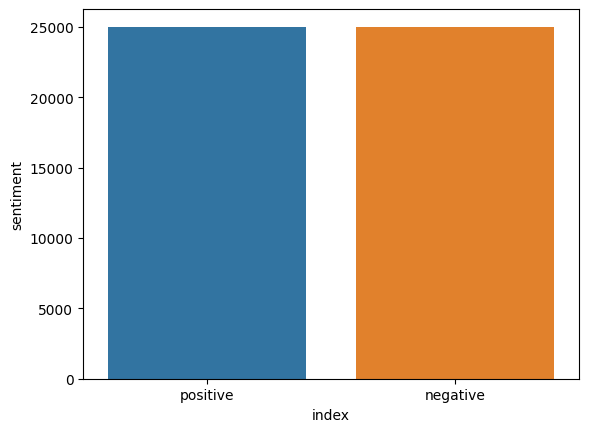

In [12]:
sns.barplot(pd.DataFrame(df.sentiment.value_counts().reset_index()), x='index', y='sentiment')

In [13]:
df.sentiment = df.sentiment.map({'positive': 1, 'negative': 0})

In [102]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Split data into Train and Test subsets

In [14]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [16]:
print(df.shape, X_train.shape, X_test.shape)

(50000, 2) (40000, 1) (10000, 1)


### Tokenize text data

In [17]:
tokenizer = Tokenizer(num_words=5000)                                                # Require tokenizer to consider only the most 5000 frequency words 
tokenizer.fit_on_texts(X_train['review'])                                            # Update the dictionary
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train['review']), maxlen=200) # Transform each word to the vector of
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test['review']), maxlen=200)   # length 200

#### Save tokenizer

In [19]:
with open(current_dir + r'\..\model\tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())

In [20]:
print(X_train)

[[   0    0    0 ...  367  157  157]
 [  42  487   46 ...   21   52   49]
 [  27    4   57 ...  539  375    9]
 ...
 [   0    0    0 ...  659   16   77]
 [ 141    3   14 ...   22   21   68]
 [   0    0    0 ...    5   65 3708]]


numpy.ndarray

In [47]:
print(X_test)

[[   0    0    0 ...    6 2362    4]
 [   0    0   10 ...    8    3 3166]
 [   0    0    0 ...    8    1   19]
 ...
 [   0    0    0 ...   13  615 2235]
 [   0    0    0 ...    1 2232  313]
 [   0    0    0 ...   93  146 1617]]


## Model building

### Model declaration

In [48]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, dropout=.2, recurrent_dropout=.2),
    Dense(1, activation='sigmoid'),
])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model training

In [52]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=.2)

Epoch 1/5
500/500 [==============================] - 545s 1s/step - loss: 0.4615 - accuracy: 0.7848 - val_loss: 0.5419 - val_accuracy: 0.7346
Epoch 2/5
500/500 [==============================] - 544s 1s/step - loss: 0.3662 - accuracy: 0.8410 - val_loss: 0.3141 - val_accuracy: 0.8735
Epoch 3/5
500/500 [==============================] - 530s 1s/step - loss: 0.2680 - accuracy: 0.8909 - val_loss: 0.3295 - val_accuracy: 0.8802
Epoch 4/5
500/500 [==============================] - 528s 1s/step - loss: 0.2221 - accuracy: 0.9134 - val_loss: 0.2813 - val_accuracy: 0.8854
Epoch 5/5
500/500 [==============================] - 574s 1s/step - loss: 0.1920 - accuracy: 0.9262 - val_loss: 0.2911 - val_accuracy: 0.8830


### Model evaluation

In [54]:
loss, accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 27ms/step - loss: 0.3063 - accuracy: 0.8750


In [55]:
print(f'''
    TEST RESULT
    Loss:     {loss}
    Accuracy: {accuracy}
''')


    TEST RESULT
    Loss:     0.30627137422561646
    Accuracy: 0.875



In [56]:
y_pred_prob = model.predict(X_test)

313/313 [==============================] - 9s 29ms/step


In [65]:
y_pred = (y_pred_prob > .5).astype(int)
cm = confusion_matrix(y_test, y_pred)

In [71]:
group_names = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.ravel()]
group_percentages = ['{0:.2%}'.format(value) for value in (cm.flatten() / np.sum(cm))]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

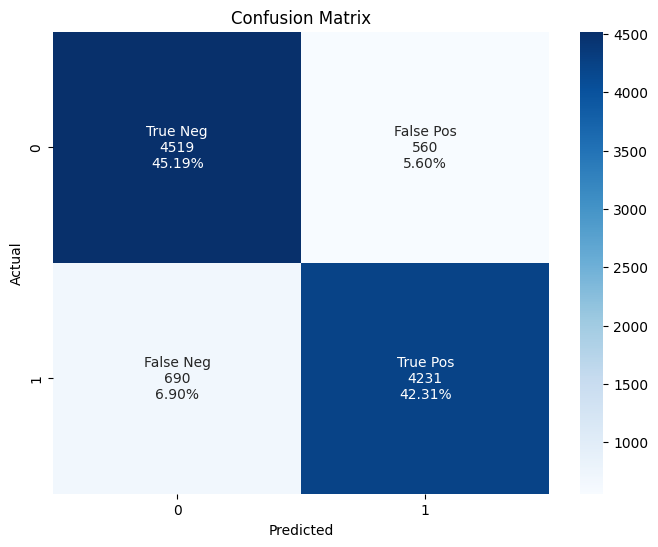

In [75]:
plt.figure(figsize=(8,6))
plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(current_dir + '\..\images\confusion_matrix.png')
plt.show()

In [80]:
clr = classification_report(y_true=y_test, y_pred=y_pred, target_names=['Negative', 'Positive'])
print(clr)


              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88      5079
    Positive       0.88      0.86      0.87      4921

    accuracy                           0.88     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.88      0.87     10000



### Save model

In [53]:
model.save(current_dir + '/../model/SentimentAnalysisonIMDB.keras')